In [1]:
# load CIFAR-100 dataset
from torchvision import datasets
from torchvision.transforms import transforms
# import neccessary libraries
import os
import sys
import json
import requests
from tqdm import tqdm
import time
import datetime
import logging
import logging.handlers
import torch
import pandas as pd
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import os
from datasets import load_dataset
import torch.nn.parallel
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset


/home/mingxu/miniconda3/envs/ML/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 标准化
])

train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
# output the CIFAR-100 classes
print(train_dataset.classes)
classes = train_dataset.classes
for i in range(100):
    # output each amount figure of classes
    print(train_dataset.targets.count(i))

Files already downloaded and verified


Files already downloaded and verified
['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle

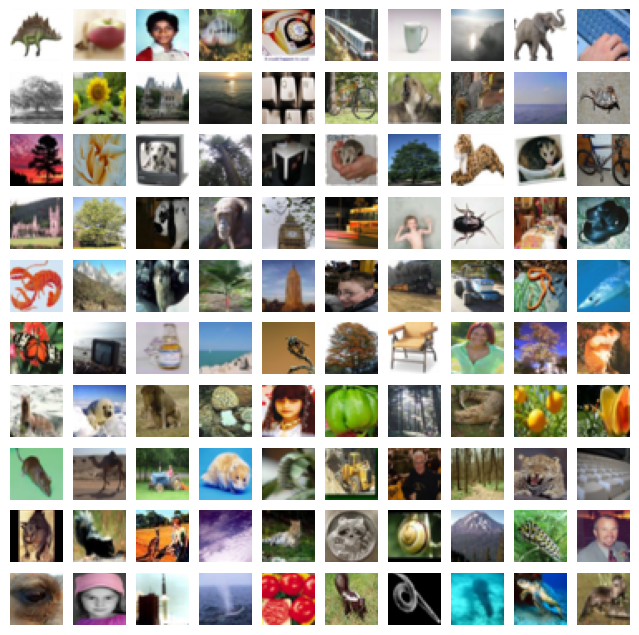

In [3]:
# each class show one figure of CIFAR-100 and showing in 10*10 grid
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 8))
columns = 10
rows = 10
for i in range(1, columns * rows + 1):
    img, label = train_dataset.data[i], train_dataset.targets[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')
plt.show()


In [4]:
# batch_size = 128 load dataset
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)


In [5]:
# print the train and test dataset sizes
print('Train: ', len(train_loader.dataset))
print('Test: ', len(test_loader.dataset))
# print the train and test batch sizes
print('Total Batch: ', len(train_loader))
print('Total Batch: ', len(test_loader))

Train:  50000
Test:  10000
Total Batch:  391
Total Batch:  79


In [6]:
import wandb
import random
wandb.init(
    project="DL_Classification_CIFAR-100",
    config={
    "learning_rate": 5e-3,
    "architecture": "Orignal_ResNet",
    "dataset": "CIFAR-100",
    "epochs": 50,
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mingxu_zhang (mingxus-team). Use `wandb login --relogin` to force relogin


In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100, dropout_rate=0.5):
        super(ResNet, self).__init__()
        self.in_channels = 32
        self.conv = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(32)
        self.layer1 = self.make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self.make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self.make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self.make_layer(block, 256, num_blocks[3], stride=2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(256, num_classes)

    def make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn(self.conv(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.dropout(out) 
        out = self.fc(out)
        return out
        
    def evaluate(self, test_loader, criterion, use_cuda):
        # calculate the accuracy on the test set
        model.eval()
        test_loss = 0.0
        class_correct = list(0. for i in range(100))
        class_total = list(0. for i in range(100))
        for data, target in tqdm(test_loader):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()*data.size(0)
            _, pred = torch.max(output, 1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            correct = np.squeeze(correct_tensor.numpy()) if not use_cuda else np.squeeze(correct_tensor.cpu().numpy())
            for i in range(len(target.data)):
                label = target.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1
        test_loss = test_loss/len(test_loader.dataset)
        for i in range(10):
            if class_total[i] > 0:
                # log accuracy of each class
                wandb.log({"acc_{}".format(classes[i]): class_correct[i] / class_total[i]})
                #print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (str(i), 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])))
            else:
                print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))  
        #wandb log the average acc
        wandb.log({"acc": np.sum(class_correct) / np.sum(class_total)})
        # print average acc
        print('Test Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)))
        

    def train_model(model, train_loader, valid_loader, epochs, optimizer, criterion, use_cuda, save_path):
        valid_loss_min = np.Inf
        count = 0
        for epoch in tqdm(range(1, epochs+1)):
            train_loss = 0.0
            valid_loss = 0.0
            model.train()
            for data, target in train_loader:
                if use_cuda:
                    data, target = data.cuda(), target.cuda()
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()*data.size(0)
            model.eval()
            for data, target in valid_loader:
                if use_cuda:
                    data, target = data.cuda(), target.cuda()
                output = model(data)
                loss = criterion(output, target)
                valid_loss += loss.item()*data.size(0)
            train_loss = train_loss/len(train_loader.sampler)
            valid_loss = valid_loss/len(valid_loader.sampler)
            model.evaluate( valid_loader, criterion, use_cuda)
            wandb.log({"training_loss": train_loss, "val_loss": valid_loss})  

            print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
            if valid_loss <= valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
                torch.save(model.state_dict(), save_path)
                valid_loss_min = valid_loss
                count = 0
            else :
                count = count + 1
                if count > 4:
                    break
            


    def predict(model, test_loader, use_cuda):
        model.eval()
        test_preds = torch.LongTensor()
        use_cuda = torch.cuda.is_available()
        for i, data in tqdm(test_loader):
            if use_cuda:
                data = data.cuda()
            output = model(data)
            preds = output.cpu().data.max(1, keepdim=True)[1]
            test_preds = torch.cat((test_preds, preds), dim=0)
        return test_preds


In [ ]:
# 输出模型的架构

model = ResNet(ResidualBlock, [5, 6, 7, 8])
print(model)

In [10]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
model = ResNet(ResidualBlock, [5, 6, 7, 8])
use_cuda = torch.cuda.is_available()
if use_cuda:
    model = model.cuda()
# train model
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
epochs = 50
ResNet.train_model(model, train_loader, test_loader, epochs, optimizer, criterion, use_cuda, 'ResNet_baseline_model.pt')


100%|██████████| 79/79 [00:03<00:00, 23.13it/s]


Test Accuracy (Overall):  9% (989/10000)
Epoch: 1 	Training Loss: 4.305073 	Validation Loss: 3.798613
Validation loss decreased (inf --> 3.798613).  Saving model ...


100%|██████████| 79/79 [00:03<00:00, 22.58it/s]


Test Accuracy (Overall): 16% (1670/10000)
Epoch: 2 	Training Loss: 3.699378 	Validation Loss: 3.378238
Validation loss decreased (3.798613 --> 3.378238).  Saving model ...


100%|██████████| 79/79 [00:03<00:00, 22.87it/s]


Test Accuracy (Overall): 25% (2527/10000)
Epoch: 3 	Training Loss: 3.262682 	Validation Loss: 2.945842
Validation loss decreased (3.378238 --> 2.945842).  Saving model ...


100%|██████████| 79/79 [00:03<00:00, 23.36it/s]


Test Accuracy (Overall): 31% (3190/10000)
Epoch: 4 	Training Loss: 2.822173 	Validation Loss: 2.596881
Validation loss decreased (2.945842 --> 2.596881).  Saving model ...


100%|██████████| 79/79 [00:03<00:00, 22.87it/s]


Test Accuracy (Overall): 36% (3685/10000)
Epoch: 5 	Training Loss: 2.466624 	Validation Loss: 2.480629
Validation loss decreased (2.596881 --> 2.480629).  Saving model ...


100%|██████████| 79/79 [00:03<00:00, 22.29it/s]


Test Accuracy (Overall): 41% (4118/10000)
Epoch: 6 	Training Loss: 2.187416 	Validation Loss: 2.182441
Validation loss decreased (2.480629 --> 2.182441).  Saving model ...


100%|██████████| 79/79 [00:03<00:00, 22.71it/s]


Test Accuracy (Overall): 42% (4239/10000)
Epoch: 7 	Training Loss: 1.950870 	Validation Loss: 2.162142
Validation loss decreased (2.182441 --> 2.162142).  Saving model ...


100%|██████████| 79/79 [00:03<00:00, 22.74it/s]


Test Accuracy (Overall): 46% (4613/10000)
Epoch: 8 	Training Loss: 1.726582 	Validation Loss: 1.975038
Validation loss decreased (2.162142 --> 1.975038).  Saving model ...


100%|██████████| 79/79 [00:03<00:00, 21.95it/s]


Test Accuracy (Overall): 48% (4899/10000)
Epoch: 9 	Training Loss: 1.502139 	Validation Loss: 1.882323
Validation loss decreased (1.975038 --> 1.882323).  Saving model ...


 20%|██        | 10/50 [05:21<21:19, 31.99s/it]

Test Accuracy (Overall): 48% (4815/10000)
Epoch: 10 	Training Loss: 1.300787 	Validation Loss: 2.009049


 22%|██▏       | 11/50 [05:53<20:47, 31.98s/it]

Test Accuracy (Overall): 49% (4921/10000)
Epoch: 11 	Training Loss: 1.095805 	Validation Loss: 2.021090


 24%|██▍       | 12/50 [06:24<20:11, 31.89s/it]

Test Accuracy (Overall): 48% (4876/10000)
Epoch: 12 	Training Loss: 0.895197 	Validation Loss: 2.111514


 26%|██▌       | 13/50 [06:56<19:37, 31.82s/it]

Test Accuracy (Overall): 49% (4951/10000)
Epoch: 13 	Training Loss: 0.726103 	Validation Loss: 2.122125


 26%|██▌       | 13/50 [07:28<21:16, 34.49s/it]

Test Accuracy (Overall): 48% (4893/10000)
Epoch: 14 	Training Loss: 0.592554 	Validation Loss: 2.338641
